# 01_EDA - Exploratory Data Analysis

This notebook loads the dataset using `src/load_data.py`, prints basic information, and creates simple plots (class distribution, amount distribution, correlation heatmap). If no CSV is found in `../data/raw/`, it will ask you to place the file there.

Loading dataset from: c:\Users\mazen\Desktop\Uni\Term 9\Data Mining\Anti-Money Laundering (AML) Detection System\aml_project\data\raw\PS_20174392719_1491204439457_log.csv

Dataset loaded successfully!
Shape: 6362620 rows, 11 columns

First 5 rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1677795071,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00


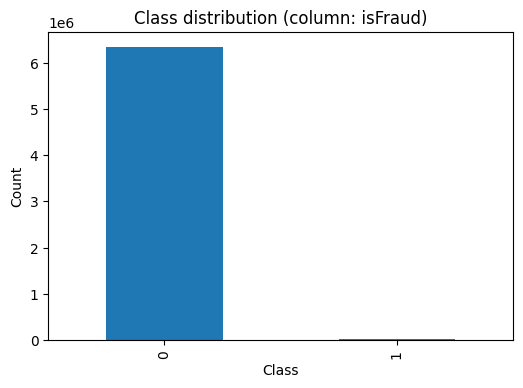

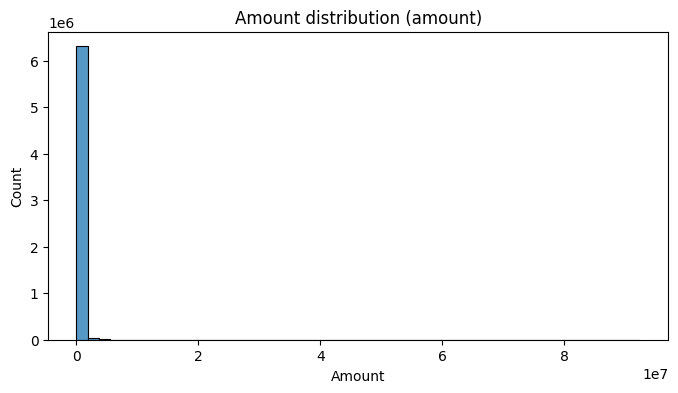

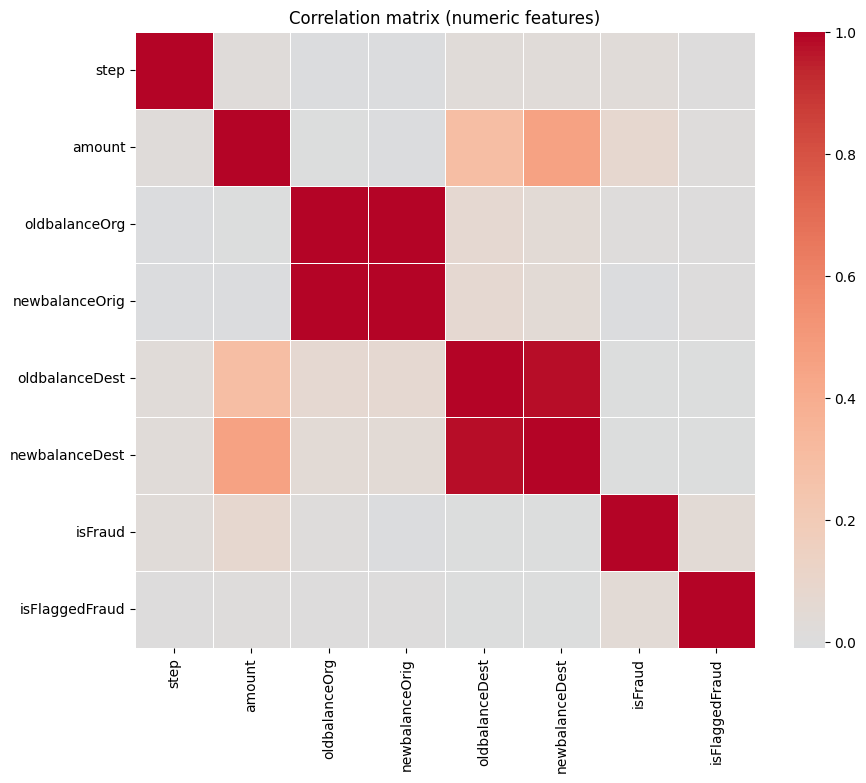

In [3]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from load_data import load_dataset, save_sample

RAW_DIR = os.path.abspath(os.path.join('..', 'data', 'raw'))
csv_files = [f for f in os.listdir(RAW_DIR) if f.lower().endswith('.csv')] if os.path.exists(RAW_DIR) else []
if not csv_files:
    print('No CSV files found in data/raw. Please place the dataset CSV in data/raw and re-run this cell.')
else:
    dataset_path = os.path.join(RAW_DIR, csv_files[0])
    df = load_dataset(dataset_path)
    save_sample(df, os.path.join(RAW_DIR, 'sample.csv'), sample_size=500)

    print('\nInfo:')
    print(df.info())

    print('\nDescribe:')
    display(df.describe(include='all'))

    # Class distribution (try common label names)
    label_cols = [c for c in df.columns if c.lower() in ('class', 'isfraud', 'label', 'fraud')]
    if label_cols:
        lbl = label_cols[0]
        counts = df[lbl].value_counts(dropna=False)
        plt.figure(figsize=(6,4))
        counts.plot(kind='bar')
        plt.title(f'Class distribution (column: {lbl})')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.show()
    else:
        print('No obvious label column found (e.g., class/isFraud). Skipping class distribution plot.')

    # Amount distribution (try to auto-detect common amount column names)
    amount_candidates = [c for c in df.columns if c.lower() in ('amount','amt','transaction_amount','amount_usd','txn_amount')]
    if amount_candidates:
        amt_col = amount_candidates[0]
        plt.figure(figsize=(8,4))
        sns.histplot(df[amt_col].dropna(), bins=50, kde=False)
        plt.title(f'Amount distribution ({amt_col})')
        plt.xlabel('Amount')
        plt.ylabel('Count')
        plt.show()
    else:
        print('No amount column detected (common names: amount, amt). Skipping amount plot.')

    # Correlation heatmap for numeric columns
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] >= 2:
        corr = num.corr()
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5)
        plt.title('Correlation matrix (numeric features)')
        plt.show()
    else:
        print('Not enough numeric columns for correlation matrix.')
